# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. If your data is in counts format, consider first transforming to log2(cpm+1) with edgeR.

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

# Begin miner analysis

## Import standard dependencies

In [70]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import imp
import miner_py3 as miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [71]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Documents','GitHub','miner3-wall','miner')

# create name for results folder where output files will be saved
resultsFolder = "miner_network_results"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load reference dictionary for mechanistic inference (skip if using default)

In [72]:
# #provide absolute path to your .csv-format reference database
# filename = os.path.join(os.path.split(os.getcwd())[0],"data","reference_database_example.csv")
# #provide absolute path to the miner/data/network_dictionaries directory where your database will be stored
network_dictionaries_path = os.path.join(input_path,"data","network_dictionaries")
network_dictionaries_path
# #name your reference database and use the extension ".pkl"
# dictionaryName = "reference_database.pkl"
# #import and save your reference database to the Python pickle format for future use
# reference_mechanistic_database = miner.fileToReferenceDictionary(filename,os.path.join(network_dictionaries_path,dictionaryName))

'/Users/serdarturkaslan/Documents/GitHub/miner3-wall/miner/data/network_dictionaries'

## 0. Load and pre-process data; set parameters

In [73]:
# Load expression Data
expressionFile = '/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020-ST/data/GbmMicroRNAMergedWithIDsZScored.csv' 
expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
#expressionData, conversionTable = miner.preprocess( expressionFile)
expressionData

,TCGA-14-1034.1,TCGA-06-0190.1,TCGA-19-4065.1,TCGA-06-0125.1,TCGA-02-0055,TCGA-06-0210.1,TCGA-06-AABW,TCGA-19-4065,TCGA-06-0211.1,TCGA-28-2499,...,TCGA-02-0456,TCGA-02-0269,TCGA-06-0397,TCGA-02-0043,TCGA-06-0413,TCGA-28-6450,TCGA-19-2623,TCGA-02-0079,TCGA-02-0281,TCGA-08-0349
ENSG00000283681,0.365340,0.859456,0.691551,0.804120,-0.063949,0.783231,1.287966,-0.145116,0.221032,-1.095594,...,0.148827,0.774041,-1.702493,-0.070572,1.447313,0.745617,0.982889,0.005778,1.400442,-1.002587
ENSG00000283630,-1.009928,-0.351957,-0.027208,-1.068849,1.158995,-0.617657,0.200077,0.562189,0.963349,0.472726,...,-0.880169,-0.508012,-0.109192,0.094321,0.015656,0.034153,1.123507,-3.855847,0.463121,0.018704
ENSG00000283590,0.552128,-0.748391,-0.329660,-0.999928,-1.074924,-0.908077,1.038520,-1.155707,-0.439210,-0.140862,...,-0.967255,0.394856,-0.412430,0.353109,-0.774273,-0.327461,-0.349840,1.494965,-1.439669,-0.513586
ENSG00000283530,-0.156090,-0.855818,0.111442,-0.447692,-0.786021,0.016428,1.272284,-0.899562,-0.874989,-0.914913,...,-0.725035,-0.185821,-0.963406,-1.296743,-0.397174,-0.388734,1.166285,0.405864,-0.862350,-0.378442
ENSG00000283494,0.336232,-0.884301,1.983644,0.362841,-0.172053,-0.825305,1.779626,-0.380914,-0.045445,-0.732519,...,0.531594,0.402358,-0.341277,-0.219411,0.584425,-0.914456,-0.155219,0.102553,-0.085131,0.158417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000000460,1.359074,0.914425,-0.774342,-1.278000,0.149360,0.095251,-1.869472,0.399595,0.192847,-1.558784,...,1.598972,0.104573,0.059672,-0.229645,0.869590,0.456252,1.911108,0.505371,-0.374221,0.452615
ENSG00000000457,1.384233,-0.609021,-1.203070,-0.343926,0.289068,-0.510084,1.030410,1.054926,0.060022,-0.919853,...,-0.332132,0.671936,-1.130524,2.037924,-0.014342,0.883297,-0.567201,-1.187497,-0.330499,-0.184599
ENSG00000000419,1.255467,0.493140,-0.117985,-1.166150,2.257780,-1.481455,-1.063548,1.250505,1.117161,-0.160586,...,0.848050,-0.506158,0.999860,0.130519,-0.267893,0.515554,-0.095078,-1.018946,-0.499471,-0.314698
ENSG00000000005,-0.177294,0.107915,-0.405752,-0.461856,4.750890,-0.256704,-0.461856,-0.422880,-0.461856,-0.327159,...,-0.589469,-0.247606,-0.593380,-0.294902,-0.360294,-0.566582,4.302339,-0.228156,-0.012230,0.478061


Text(0.5, 0, 'Relative expression')

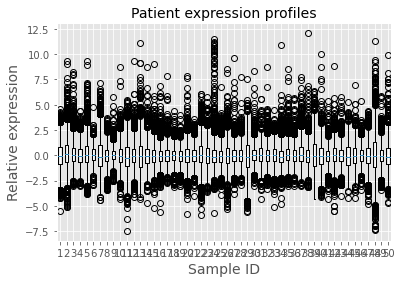

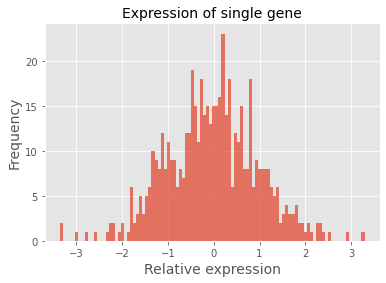

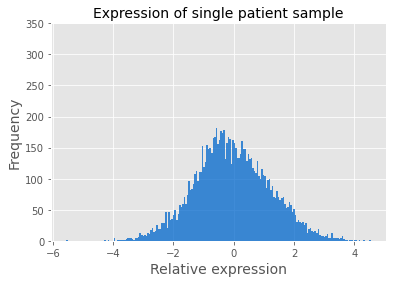

In [74]:
# Visualize pre-processed expression data
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",fontsize=14)
plt.ylabel("Relative expression",fontsize=14)
plt.xlabel("Sample ID",fontsize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xlabel("Relative expression",fontsize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xlabel("Relative expression",fontsize=14)

## Set parameters

In [75]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = network_dictionaries_path + "/tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 5

# 1. Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 0.92 minutes
Completed coexpression clustering in 1.26 minutes
Number of genes clustered: 9030
Number of unique clusters: 635
Completed clustering module in 1.26 minutes


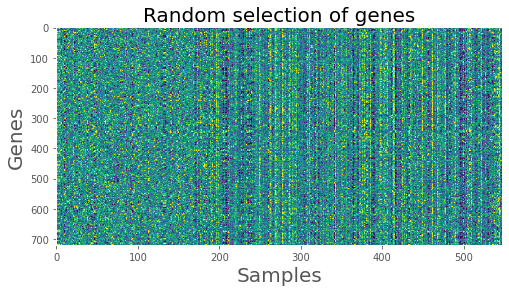

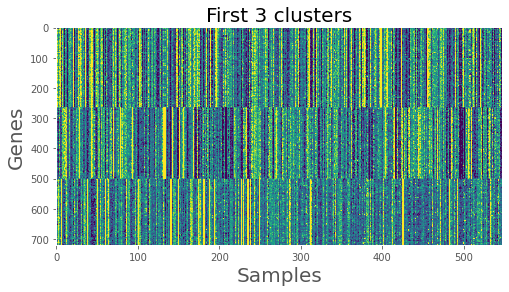

In [76]:
# Network inference may take several minutes. 
# Prompts will print at 0, 20, 40, 60, 80, and 100% complete

t1 = time.time() 
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=17,overExpressionThreshold=80) 

# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)

# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

t2 = time.time()
print("Completed coexpression clustering in {:.2f} minutes".format((t2-t1)/60.))

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(
    expressionData.index,len(first_clusters),
    replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",fontsize=20)
plt.xlabel("Samples",fontsize=20)
plt.title("Random selection of genes",fontsize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",fontsize=20)
plt.xlabel("Samples",fontsize=20)
plt.title("First 3 clusters",fontsize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t3 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t3-t1)/60.))

# 2. Mechanistic inference

In [77]:
import sys
imp.reload(miner)
t1 = time.time()

#revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))

# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)

# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)

# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulonModules,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)
#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

Running mechanistic inference


/Users/serdarturkaslan/Documents/GitHub/GbmMINER/src/miner_py3.py:1395: RuntimeWarning: invalid value encountered in greater_equal
  def multiprocess(function,tasks):


Completed mechanistic inference in 3.23 minutes
Inferred network with 3824 regulons, 428 regulators, and 6677 co-regulated genes


# 3. Expand regulons (optional, not default)

In [61]:
t1 = time.time()
tfbsdbGenes_file = os.path.join(input_path,"data","network_dictionaries","tfbsdb_genes_to_tf.pkl")
expandedRegulons = miner.parallelRegulonExpansion(eigengenes,regulonModules,regulonDf,
                                                  expressionData,tfbsdbGenes_file,
                                                  overExpressedMembersMatrix,
                                                  corrThreshold = 0.25,auc_threshold = 0.70,
                                                  numCores=5)

regulonIDtoRegulator = miner.regulonIdToRegulator(regulonDf)
expandedRegulonDf = miner.regulonDictToDf(expandedRegulons,regulonIDtoRegulator)
t2 = time.time()
print("Completed regulon expansion in {:.2f} minutes".format((t2-t1)/float(60.)))

expandedEigengenes = miner.getEigengenes(expandedRegulons,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(expandedEigengenes,95)
expandedEigengenes = eigenScale*expandedEigengenes
expandedEigengenes.index = np.array(expandedEigengenes.index).astype(str)

NameError: name 'overExpressedMembersMatrix' is not defined

In [18]:
expandedEigengenes.to_csv(os.path.join(resultsDirectory,"expanded_eigengenes.csv"))
expandedRegulonDf.to_csv(os.path.join(resultsDirectory,"expanded_regulonDf.csv"))
miner.write_json(expandedRegulons,os.path.join(resultsDirectory,"expanded_regulons.json"))
print("Expanded network to {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(expandedRegulonDf.Regulon_ID.unique()),
                                                                                                 len(expandedRegulonDf.Regulator.unique()),
                                                                                                 len(expandedRegulonDf.Gene.unique())))

Expanded network to 3646 regulons, 422 regulators, and 10118 co-regulated genes


# 4. Causal inference

In [85]:
imp.reload(miner)

referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes

# Load mutations
common_mutations_file = "/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020-ST/data/mutations.GBM.TCGA.2019.05.01.csv"
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)
#mut_matrix = common_mutations.copy()
#miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

sigSomatic_mutations_file = "/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020-ST/data/SignificantSomaticMutationsGbmRNAAndMicroarray07242020.csv"
sigSomatic_mutations = pd.read_csv(sigSomatic_mutations_file,index_col=0,header=0)
#mut_matrix = common_mutations.copy()
#miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

nonSilentPathway_mutations_file = "/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020-ST/data/NonSilentPathwayMutationsGbmRNAAndMicroarray07242020.csv"
nonSilentPathway_mutations = pd.read_csv(nonSilentPathway_mutations_file,index_col=0,header=0)
#mut_matrix = common_mutations.copy()
#miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = sigSomatic_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = nonSilentPathway_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

completed causal analysis in 18.15 minutes
completed causal analysis in 0.59 minutes
completed causal analysis in 1.33 minutes


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned,Fraction_of_aligned_and_diff_exp_edges,number_downstream_regulons,number_differentially_expressed_regulons
1106,USP35_code_potential_somatic,ENSG00000163848,R-1106,1.0,3.319541,0.590543,8.225260e-53,8.604207,2.883883,1.0,0.040000,25,1
3079,USP35_code_potential_somatic,ENSG00000276561,R-3079,-1.0,1.647875,0.782169,2.850323e-114,-4.815481,1.524340,1.0,0.117647,17,2
3092,USP35_code_potential_somatic,ENSG00000276561,R-3092,-1.0,1.647875,0.382063,1.731045e-20,-4.085167,1.305040,1.0,0.117647,17,2
960,USP35_code_potential_somatic,ENSG00000115415,R-960,-1.0,1.758098,0.330568,1.939187e-15,-5.415405,1.555208,0.5,0.045455,22,2
2269,USP35_code_potential_somatic,ENSG00000197063,R-2269,1.0,2.275803,-0.194685,4.410132e-06,-4.825915,1.598163,1.0,0.083333,12,1


In [86]:
# filtered causal results
causal_results_regulon_filtered = causal_results[causal_results["-log10(p)_Regulon_stratification"]>=-np.log10(0.05)]
causal_results_aligned = causal_results_regulon_filtered[causal_results_regulon_filtered.Fraction_of_edges_correctly_aligned>=0.5]
causal_results_aligned_correlated = causal_results_aligned[causal_results_aligned["RegulatorRegulon_Spearman_p-value"]<=0.05]
causal_results_stratified_aligned_correlated = causal_results_aligned_correlated[causal_results_aligned_correlated["-log10(p)_MutationRegulatorEdge"]>=-np.log10(0.05)]

# for all causal flows, 
# the regulon is differentially active w.r.t the mutation,
# the regulator is differentially active w.r.t the mutation,
# the regulator is significantly correlated to the regulon,
# and the directionality of at least half of the differentially active targets 
# downstream of the regulator are consistent with the perturbation from the mutation

causal_results_stratified_aligned_correlated.to_csv(os.path.join(resultsDirectory,"filteredCausalResults.csv"))

# 5. Network mapping

In [78]:
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 0.72 minutes


Text(0.5, 0, 'Samples')

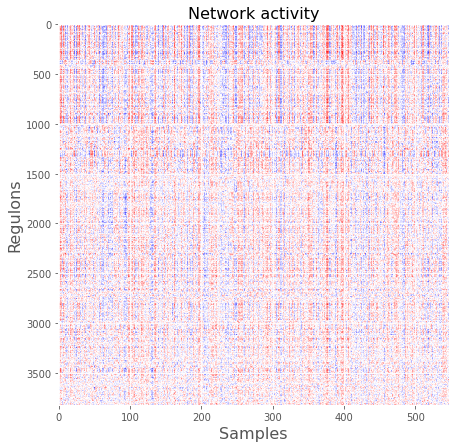

In [79]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",fontsize=16)
plt.ylabel("Regulons",fontsize=16)
plt.xlabel("Samples",fontsize=16)

# 6. Subtype discovery

In [80]:
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
states_dictionary = {str(i):states[i] for i in range(len(states))}
miner.write_json(states_dictionary,os.path.join(resultsDirectory,"transcriptional_states.json"))

Beginning subtype inference
completed subtype inference in 0.23 minutes


/Users/serdarturkaslan/Documents/GitHub/GbmMINER/src/miner_py3.py:2215: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  for i in range(dfr.shape[0]):
/Users/serdarturkaslan/Documents/GitHub/GbmMINER/src/miner_py3.py:2216: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  lowResolutionPrograms[choice[i]].append(dfr.index[i])


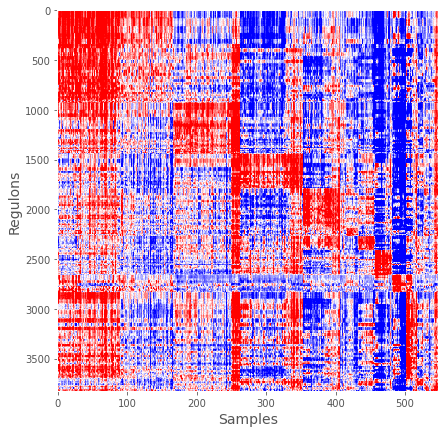

In [81]:
# Infer transcriptional programs
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=reference_df,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
miner.write_json(programs_dictionary,os.path.join(resultsDirectory,"transcriptional_programs.json"))
mosaicDf = reference_df.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

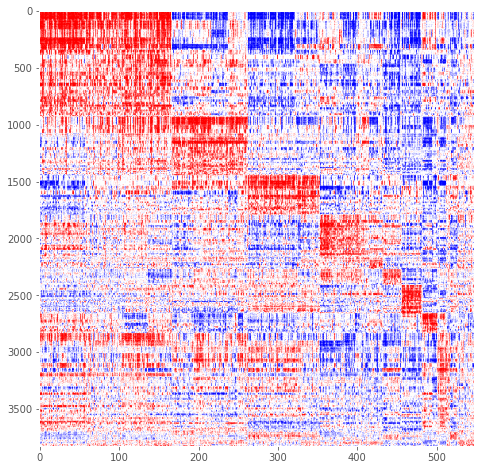

In [82]:
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"mosaic_all.pdf"),bbox_inches="tight")

/Users/serdarturkaslan/Documents/GitHub/GbmMINER/src/miner_py3.py:3345: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/Users/serdarturkaslan/Documents/GitHub/GbmMINER/src/miner_py3.py:3346: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  def getStratifyingRegulons(states_list_1,states_list_2,reference_matrix,p=0.05,plot=True):
/Users/serdarturkaslan/Documents/GitHub/GbmMINER/src/miner_py3.py:3369: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/Users/serdarturkaslan/Documents/GitHub/GbmMINER/src/miner_py3.py:3370: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if plot is True:


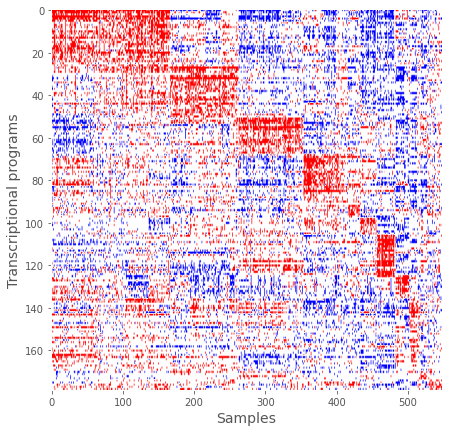

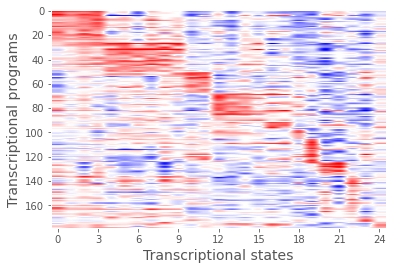

In [83]:
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"transcriptional_programs.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"),showplot=True)